In [5]:
pip install pulp

In [6]:
import math
from math import pi, pow, sin, cos, asin, sqrt, floor
import pandas as pd
from scipy import stats
import itertools
import numpy as np
from pyproj import Proj
import requests
import pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpSolverDefault
import geopandas as gpd
import requests
from io import BytesIO
import zipfile
import matplotlib.pyplot as plt

In [7]:
def degrees_to_radians(x):
     return((pi/180)*x)

def lon_lat_distance_miles(lon_a,lat_a,lon_b,lat_b):
    radius_of_earth = 24872/(2*pi)
    c = sin((degrees_to_radians(lat_a) - \
    degrees_to_radians(lat_b))/2)**2 + \
    cos(degrees_to_radians(lat_a)) * \
    cos(degrees_to_radians(lat_b)) * \
    sin((degrees_to_radians(lon_a) - \
    degrees_to_radians(lon_b))/2)**2
    return(2 * radius_of_earth * (asin(sqrt(c))))

def lon_lat_distance_meters (lon_a,lat_a,lon_b,lat_b):
    return(lon_lat_distance_miles(lon_a,lat_a,lon_b,lat_b) * 1609.34)

# UTM zone may be computed directly from the list of longitude values
def findZone(listOfLon):
    zones = [ ((floor((long + 180)/6) ) % 60) + 1 for long in listOfLon]
    zone = stats.mode(zones, keepdims = False)[0].astype(int)
    return(zone.item())

def download_shapefiles(url):
    r = requests.get(url)
    z = zipfile.ZipFile(BytesIO(r.content))
    z.extractall(path='shapefiles/')  # extracts into folder 'shapefiles/'

In [8]:
df_michigan = pd.read_excel('Michigan_Stats.xlsx')

In [9]:
df_michigan

,Full County,County,2024 Population,Growth since 2020,Area,Density,lat,lng,Republican,Democrat
0,Wayne County,Wayne,1743396,-0.0258,236,2849,42.2819,-83.2822,264553,597170
1,Oakland County,Oakland,1269827,-0.0021,335,1465,42.6604,-83.3858,325971,434148
2,Macomb County,Macomb,875967,-0.0049,185,1829,42.6957,-82.9323,263863,223952
3,Kent County,Kent,663788,0.0080,328,782,43.0322,-85.5493,165741,187915
4,Genesee County,Genesee,401121,-0.0115,246,630,43.0217,-83.7067,98714,119390
...,...,...,...,...,...,...,...,...,...,...
78,Baraga County,Baraga,8337,0.0239,347,9,46.6626,-88.3652,2512,1478
79,Schoolcraft County,Schoolcraft,8124,0.0083,452,7,46.1966,-86.1996,3090,1589
80,Luce County,Luce,6596,0.0287,347,7,46.4707,-85.5444,2109,842
81,Ontonagon County,Ontonagon,5891,0.0150,506,4,46.6644,-89.3148,2358,1391


In [10]:
counties = [
    "Wayne", "Oakland", "Macomb", "Kent", "Genesee", "Washtenaw", "Ottawa", "Ingham",
    "Kalamazoo", "Livingston", "Saginaw", "Muskegon", "St. Clair", "Jackson", "Monroe",
    "Berrien", "Calhoun", "Allegan", "Eaton", "Bay", "Lenawee", "Grand Traverse", "Lapeer",
    "Midland", "Clinton", "Van Buren", "Montcalm", "Shiawassee", "Marquette", "Ionia",
    "Barry", "Isabella", "St. Joseph", "Tuscola", "Cass", "Newaygo", "Branch", "Hillsdale",
    "Gratiot", "Mecosta", "Sanilac", "Houghton", "Delta", "Chippewa", "Wexford", "Emmet",
    "Clare", "Huron", "Mason", "Alpena", "Oceana", "Charlevoix", "Cheboygan", "Gladwin",
    "Dickinson", "Otsego", "Manistee", "Iosco", "Antrim", "Roscommon", "Osceola", "Leelanau",
    "Menominee", "Ogemaw", "Kalkaska", "Benzie", "Missaukee", "Arenac", "Gogebic", "Crawford",
    "Presque Isle", "Lake", "Iron", "Mackinac", "Alcona", "Montmorency", "Alger", "Oscoda",
    "Baraga", "Schoolcraft", "Luce", "Ontonagon", "Keweenaw"
]

populations = {
    "Wayne": 1743396, "Oakland": 1269827, "Macomb": 875967, "Kent": 663788, "Genesee": 401121,
    "Washtenaw": 364568, "Ottawa": 305826, "Ingham": 285797, "Kalamazoo": 263538, "Livingston": 197380,
    "Saginaw": 187191, "Muskegon": 177589, "St. Clair": 160080, "Jackson": 159090, "Monroe": 154855,
    "Berrien": 151687, "Calhoun": 133308, "Allegan": 122588, "Eaton": 108786, "Bay": 102362,
    "Lenawee": 96760, "Grand Traverse": 96544, "Lapeer": 89322, "Midland": 84316, "Clinton": 79788,
    "Van Buren": 75927, "Montcalm": 69099, "Shiawassee": 68083, "Marquette": 67450, "Ionia": 65688,
    "Barry": 64214, "Isabella": 63870, "St. Joseph": 60978, "Tuscola": 52744, "Cass": 51807,
    "Newaygo": 51488, "Branch": 45928, "Hillsdale": 45439, "Gratiot": 41632, "Mecosta": 41416,
    "Sanilac": 40254, "Houghton": 38038, "Delta": 36799, "Chippewa": 36321, "Wexford": 34226,
    "Emmet": 34031, "Clare": 31325, "Huron": 30709, "Mason": 29000, "Alpena": 28975,
    "Oceana": 27042, "Charlevoix": 26145, "Cheboygan": 26132, "Gladwin": 26085, "Dickinson": 26021,
    "Otsego": 25933, "Manistee": 25759, "Iosco": 25273, "Antrim": 24553, "Roscommon": 24044,
    "Osceola": 23381, "Leelanau": 23155, "Menominee": 22665, "Ogemaw": 21061, "Kalkaska": 18736,
    "Benzie": 18555, "Missaukee": 15390, "Arenac": 15167, "Gogebic": 14071, "Crawford": 13642,
    "Presque Isle": 13227, "Lake": 12817, "Iron": 11775, "Mackinac": 10740, "Alcona": 10581,
    "Montmorency": 9799, "Alger": 8741, "Oscoda": 8699, "Baraga": 8337, "Schoolcraft": 8124,
    "Luce": 6596, "Ontonagon": 5891, "Keweenaw": 2189
}


Republican_Votes = {
    "Wayne": 264553, "Oakland": 325971, "Macomb": 263863, "Kent": 165741, "Genesee": 98714,
    "Washtenaw": 56241, "Ottawa": 100913, "Ingham": 47639, "Kalamazoo": 56823, "Livingston": 76982,
    "Saginaw": 50785, "Muskegon": 45133, "St. Clair": 59185, "Jackson": 47372, "Monroe": 52710,
    "Berrien": 43519, "Calhoun": 36221, "Allegan": 41392, "Eaton": 31798, "Bay": 33125,
    "Lenawee": 31541, "Grand Traverse": 30502, "Lapeer": 35482, "Midland": 27675, "Clinton": 25098,
    "Van Buren": 21591, "Montcalm": 21815, "Shiawassee": 23149, "Marquette": 16286, "Ionia": 20657,
    "Barry": 23471, "Isabella": 14815, "St. Joseph": 18127, "Tuscola": 20297, "Cass": 16699,
    "Newaygo": 18857, "Branch": 14064, "Hillsdale": 17037, "Gratiot": 12102, "Mecosta": 13267,
    "Sanilac": 16194, "Houghton": 10378, "Delta": 13207, "Chippewa": 10681, "Wexford": 12102,
    "Emmet": 12135, "Clare": 10861, "Huron": 12731, "Mason": 10207, "Alpena": 10686,
    "Oceana": 8892, "Charlevoix": 9841, "Cheboygan": 10186, "Gladwin": 9893, "Dickinson": 9617,
    "Otsego": 9779, "Manistee": 8321, "Iosco": 9759, "Antrim": 9748, "Roscommon": 9670,
    "Osceola": 8928, "Leelanau": 7916, "Menominee": 8117, "Ogemaw": 8253, "Kalkaska": 7436,
    "Benzie": 6601, "Missaukee": 6648, "Arenac": 5928, "Gogebic": 4600, "Crawford": 5087,
    "Presque Isle": 5342, "Lake": 3946, "Iron": 4216, "Mackinac": 4304, "Alcona": 4848,
    "Montmorency": 4171, "Alger": 3014, "Oscoda": 3466, "Baraga": 2512, "Schoolcraft": 3090,
    "Luce": 2109, "Ontonagon": 2358, "Keweenaw": 862
}

Democratic_Votes = {
    "Wayne": 597170, "Oakland": 434148, "Macomb": 223952, "Kent": 187915, "Genesee": 119390,
    "Washtenaw": 157136, "Ottawa": 64705, "Ingham": 94212, "Kalamazoo": 83686, "Livingston": 48220,
    "Saginaw": 51088, "Muskegon": 45643, "St. Clair": 31363, "Jackson": 31995, "Monroe": 32975,
    "Berrien": 37438, "Calhoun": 28877, "Allegan": 24449, "Eaton": 31299, "Bay": 26151,
    "Lenawee": 20918, "Grand Traverse": 28683, "Lapeer": 16367, "Midland": 20493, "Clinton": 21968,
    "Van Buren": 16803, "Montcalm": 9703, "Shiawassee": 15347, "Marquette": 20465, "Ionia": 10901,
    "Barry": 11797, "Isabella": 14072, "St. Joseph": 9262, "Tuscola": 8712, "Cass": 9130,
    "Newaygo": 7873, "Branch": 6159, "Hillsdale": 5883, "Gratiot": 6693, "Mecosta": 7375,
    "Sanilac": 5966, "Houghton": 7750, "Delta": 7606, "Chippewa": 6648, "Wexford": 5838,
    "Emmet": 9662, "Clare": 5199, "Huron": 5490, "Mason": 6802, "Alpena": 6000,
    "Oceana": 4944, "Charlevoix": 6939, "Cheboygan": 5437, "Gladwin": 4524, "Dickinson": 4744,
    "Otsego": 4743, "Manistee": 6107, "Iosco": 5373, "Antrim": 5960, "Roscommon": 5166,
    "Osceola": 3214, "Leelanau": 8795, "Menominee": 4316, "Ogemaw": 3475, "Kalkaska": 3002,
    "Benzie": 5480, "Missaukee": 1967, "Arenac": 2774, "Gogebic": 3570, "Crawford": 2672,
    "Presque Isle": 2911, "Lake": 2288, "Iron": 2493, "Mackinac": 2632, "Alcona": 2142,
    "Montmorency": 1628, "Alger": 2053, "Oscoda": 1342, "Baraga": 1478, "Schoolcraft": 1589,
    "Luce": 842, "Ontonagon": 1391, "Keweenaw": 672
}


In [11]:
# create dictionary of adjacent counties
url = 'https://www2.census.gov/geo/docs/reference/county_adjacency.txt'
resp = requests.get(url)
data = resp.text

adjacent_counties = {}
county = None
state = None
neighbor_state = None

# read one line at a time
for line in data.splitlines():
  tokens = line.split("\t") #split the line on tabs

  if len(tokens) == 4 and tokens[0]:
    county, state = tokens[0].strip('"').split(',')
    county = ' '.join(part for part in county.split() if part != "County") # remove 'County'
    state = state.strip()

    if state == "MI":
      adjacent_counties[county] = []
      #print(county)

      # for some reason the list of adjacent counties starts at the same line
      neighbor, neighbor_state = tokens[2].strip('"').split(',')
      neighbor = ' '.join(part for part in neighbor.split() if part != "County")
      neighbor_state = state.strip()

      if neighbor_state == "MI" and neighbor != county:
        adjacent_counties[county].append(neighbor)
        #print(f"\t{neighbor}")


  elif state == "MI":
    neighbor, neighbor_state = tokens[2].strip('"').split(',')
    neighbor = ' '.join(part for part in neighbor.split() if part != "County")
    neighbor_state = state.strip()

    if neighbor_state == "MI" and neighbor != county:
      adjacent_counties[county].append(neighbor)
      #print(f"\t{neighbor}")

#print(adjacent_counties)

In [12]:
county_pairs = list(itertools.product(counties, repeat=2))
distances = {}

for (county1, county2) in county_pairs:
    lat1 =  df_michigan.loc[df_michigan['County'] == county1, 'lat'].values[0]
    lon1 = df_michigan.loc[df_michigan['County'] == county1, 'lng'].values[0]
    lat2 = df_michigan.loc[df_michigan['County'] == county2, 'lat'].values[0]
    lon2 = df_michigan.loc[df_michigan['County'] == county2, 'lng'].values[0]
    distance = lon_lat_distance_miles(lat1, lon1, lat2, lon2)
    distances[(county1, county2)] = round(distance,2)

# Now, distances dictionary holds the distances between each pair
# print(distances)a

In [13]:
# Constants
districts = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
num_districts = len(districts)
total_population = sum(populations.values())
target_population = total_population / num_districts
pop_delta = 1200000
pol_delta = 500000

# Problem setup
prob = LpProblem("Redistricting", LpMinimize)

# Decision variables
district_assignment = LpVariable.dicts("x", ((county, district) for county in counties for district in districts), cat='Binary')
same_district = LpVariable.dicts("y", ((i, k) for i in counties for k in counties if i < k), cat='Binary')

# Objective function: Minimize the weighted sum of distances between counties in the same district
prob += lpSum(distances[(i, k)] * same_district[i, k] for i in counties for k in counties if i < k)

# Constraints
# Each county must be in exactly one district
for county in counties:
    prob += lpSum(district_assignment[county, district] for district in districts) == 1, f"OneDistrict_{county}"

# Population balance constraints
for district in districts:
    prob += lpSum(populations[county] * district_assignment[county, district] for county in counties) <= target_population + pop_delta, f"PopUpper_{district}"
    prob += lpSum(populations[county] * district_assignment[county, district] for county in counties) >= target_population - pop_delta, f"PopLower_{district}"

# Add political balance constraints
for district in districts:
    prob += lpSum(Republican_Votes[county] * district_assignment[county, district] - Democratic_Votes[county] * district_assignment[county, district] for county in counties) <= pol_delta, f"PoliticalBalanceUpper_{district}"
    prob += lpSum(Democratic_Votes[county] * district_assignment[county, district] - Republican_Votes[county] * district_assignment[county, district] for county in counties) <= pol_delta, f"PoliticalBalanceLower_{district}"


# Contiguity constraints
for district in districts:
    for county in counties:
        adjacent_vars = [district_assignment[neighbor, district] for neighbor in adjacent_counties[county] if neighbor in counties]
        if adjacent_vars:
            prob += district_assignment[county, district] <= lpSum(adjacent_vars), f"Contiguity_{county}_{district}"

# Solve the problem
prob.solve()

# Output results
for v in prob.variables():
    if v.varValue > 0:
        print(f"{v.name} = {v.varValue}")

x_('Alcona',_'6') = 1.0
x_('Alger',_'10') = 1.0
x_('Allegan',_'10') = 1.0
x_('Alpena',_'12') = 1.0
x_('Antrim',_'1') = 1.0
x_('Arenac',_'1') = 1.0
x_('Baraga',_'1') = 1.0
x_('Barry',_'10') = 1.0
x_('Bay',_'1') = 1.0
x_('Benzie',_'10') = 1.0
x_('Berrien',_'1') = 1.0
x_('Branch',_'1') = 1.0
x_('Calhoun',_'1') = 1.0
x_('Cass',_'1') = 1.0
x_('Charlevoix',_'1') = 1.0
x_('Cheboygan',_'1') = 1.0
x_('Chippewa',_'1') = 1.0
x_('Clare',_'10') = 1.0
x_('Clinton',_'10') = 1.0
x_('Crawford',_'1') = 1.0
x_('Delta',_'1') = 1.0
x_('Dickinson',_'8') = 1.0
x_('Eaton',_'2') = 1.0
x_('Emmet',_'1') = 1.0
x_('Genesee',_'1') = 1.0
x_('Gladwin',_'1') = 1.0
x_('Gogebic',_'1') = 1.0
x_('Grand_Traverse',_'10') = 1.0
x_('Gratiot',_'1') = 1.0
x_('Hillsdale',_'10') = 1.0
x_('Houghton',_'3') = 1.0
x_('Huron',_'9') = 1.0
x_('Ingham',_'2') = 1.0
x_('Ionia',_'1') = 1.0
x_('Iosco',_'1') = 1.0
x_('Iron',_'1') = 1.0
x_('Isabella',_'11') = 1.0
x_('Jackson',_'1') = 1.0
x_('Kalamazoo',_'10') = 1.0
x_('Kalkaska',_'1') = 1.0
x_

In [14]:
# print nicely
districts_to_counties = {}

for v in prob.variables():
    if v.varValue == 1:
        # x_(County),_(District)"
        parts = v.name.split('x_(')[1].split(')')[0].split(',')
        county = parts[0].strip().replace('_', ' ') # handle county underscores
        district = int(''.join(filter(str.isdigit, parts[1])))

        if district not in districts_to_counties:
            districts_to_counties[district] = []
        districts_to_counties[district].append(county)

for district, counties in sorted(districts_to_counties.items()):
    cleaned_counties = sorted(counties)
    print(f"District {district}: {', '.join(cleaned_counties)}")


District 1: 'Antrim', 'Arenac', 'Baraga', 'Bay', 'Berrien', 'Branch', 'Calhoun', 'Cass', 'Charlevoix', 'Cheboygan', 'Chippewa', 'Crawford', 'Delta', 'Emmet', 'Genesee', 'Gladwin', 'Gogebic', 'Gratiot', 'Ionia', 'Iosco', 'Iron', 'Jackson', 'Kalkaska', 'Lake', 'Leelanau', 'Mackinac', 'Manistee', 'Marquette', 'Missaukee', 'Montmorency', 'Newaygo', 'Otsego', 'Presque Isle', 'Roscommon', 'Schoolcraft', 'Shiawassee', 'Van Buren', 'Wexford'
District 2: 'Eaton', 'Ingham', 'Livingston'
District 3: 'Houghton', 'Ontonagon'
District 6: 'Alcona', 'Ogemaw'
District 8: 'Dickinson', 'Menominee', 'Oakland', 'Washtenaw'
District 9: 'Huron', 'Tuscola'
District 10: 'Alger', 'Allegan', 'Barry', 'Benzie', 'Clare', 'Clinton', 'Grand Traverse', 'Hillsdale', 'Kalamazoo', 'Keweenaw', 'Lenawee', 'Luce', 'Mason', 'Montcalm', 'Oceana', 'Osceola', 'Ottawa', 'Sanilac', 'St. Clair', 'St. Joseph'
District 11: 'Isabella', 'Kent', 'Lapeer', 'Macomb', 'Mecosta', 'Muskegon'
District 12: 'Alpena', 'Monroe', 'Oscoda', 'Wayn

In [15]:
# Formatting for map creation
district_mapping = {}

for v in prob.variables():
    if v.varValue == 1:
        # x_(County),_(District)"
        parts = v.name.split('x_(')[1].split(')')[0].split(',')
        county = parts[0].strip(" '").replace('_', ' ')
        district = int(''.join(filter(str.isdigit, parts[1])))
        district_mapping[county] = int(district)

#district_mapping

In [16]:
# URL for the 2020 US Counties Shapefile (Nationwide)
url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip"

# Download and extract shapefiles
download_shapefiles(url)

# Load shapefile using geopandas
gdf = gpd.read_file('shapefiles/cb_2020_us_county_20m.shp')

# Filter for Michigan counties (state FIPS code for Michigan is '26')
michigan_counties = gdf[gdf['STATEFP'] == '26']

# Show the first few rows to verify
print(michigan_counties.head())


   STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID            NAME  \
33      26      089  01622987  0500000US26089  26089        Leelanau   
44      26      073  01622979  0500000US26073  26073        Isabella   
67      26      055  01622970  0500000US26055  26055  Grand Traverse   
78      26      035  01622960  0500000US26035  26035           Clare   
97      26      071  01622978  0500000US26071  26071            Iron   

                 NAMELSAD STUSPS STATE_NAME LSAD       ALAND      AWATER  \
33        Leelanau County     MI   Michigan   06   899241892  5659105321   
44        Isabella County     MI   Michigan   06  1483282659    12948097   
67  Grand Traverse County     MI   Michigan   06  1202625102   354771224   
78           Clare County     MI   Michigan   06  1461703751    28496979   
97            Iron County     MI   Michigan   06  3019919276   116800609   

                                             geometry  
33  MULTIPOLYGON (((-86.06597 44.82152, -86.05886 ... 

In [17]:
# Apply the district mapping
michigan_counties['District'] = michigan_counties['NAME'].map(district_mapping)

# Check missing districts
print(michigan_counties[michigan_counties['District'].isnull()])


Empty GeoDataFrame
Columns: [STATEFP, COUNTYFP, COUNTYNS, AFFGEOID, GEOID, NAME, NAMELSAD, STUSPS, STATE_NAME, LSAD, ALAND, AWATER, geometry, District]
Index: []


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


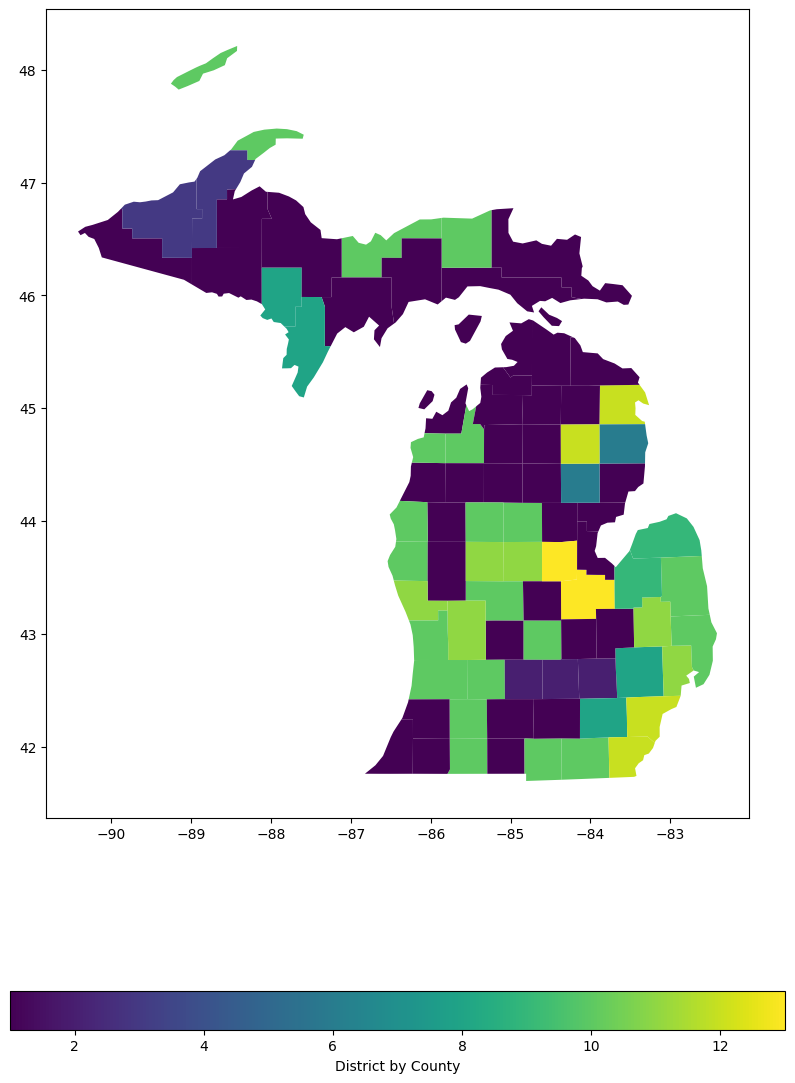

In [18]:
# Plotting the map with districts
fig, ax = plt.subplots(1, figsize=(10, 15))
michigan_counties.plot(column='District', ax=ax, legend=True,
                       legend_kwds={'label': "District by County", 'orientation': "horizontal"})
plt.show()
